<<목차>>

0. 필요한 패키지 임포트
1. 데이터 불러오기
2. 데이터 전처리
3. 모델에 넣을 데이터 정하기
4. 여러가지 Regressor 중 RMSE(Root Mean Square Error;평균 제곱근 오차)가 가장 낮은 모델 찾기
5. 모델링하여 결과값 만들기
6. 변수 중요도(Feature Importance) 그려서 저장하기
7. 월별 머신러닝 모델들의 성능(RMSE) 비교

# 0. 필요한 패키지 임포트

In [1]:
import sklearn
import numpy as np
import pandas as pd
import os
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from xgboost import XGBClassifier, XGBRegressor
import xgboost
import lightgbm as lgb
import pickle as pkl
import matplotlib.pyplot as plt
from matplotlib.pylab import rcParams
import matplotlib
import warnings


warnings.filterwarnings(action='ignore')

In [2]:
print(np.__version__)
print(pd.__version__)
print(pkl.format_version)
print(sklearn.__version__)
print(xgboost.__version__)
print(lgb.__version__)

1.19.1
1.1.1
4.0
0.23.2
1.1.0
2.3.0


# 1. 데이터 불러오기
##### 사용한 데이터 : 그리드별 월단위 통합 탐색 (20200825_아파트 매매가 추가).pickle

In [3]:
os.chdir('./데이터')   # 파일 경로 설정

In [5]:
with open('그리드별 월단위 통합 탐색 (20200825_아파트 매매가 추가).pickle', 'rb') as f:
    dataset_original = pkl.load(f)
dataset=dataset_original
dataset.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 9003120 entries, 0 to 9003119
Data columns (total 81 columns):
 #   Column            Dtype  
---  ------            -----  
 0   id                float64
 1   조사년도              int64  
 2   조사월               int64  
 3   단속활동유무            bool   
 4   적발횟수_0            int64  
 5   적발횟수_1            int64  
 6   적발횟수_2            int64  
 7   적발횟수_3            int64  
 8   적발횟수_4            int64  
 9   적발횟수_5            int64  
 10  적발횟수_6            int64  
 11  돼지고기              int64  
 12  소고기               int64  
 13  닭고기               int64  
 14  김치                int64  
 15  쌀                 int64  
 16  콩                 int64  
 17  기타                int64  
 18  미위반               int64  
 19  일반음식점_미위반         int64  
 20  식육 판매업_미위반        int64  
 21  슈퍼_미위반            int64  
 22  가공업체_미위반          int64  
 23  양곡상_미위반           int64  
 24  휴게음식점_미위반         int64  
 25  기타_미위반            int64  
 26  일반음식점_위반      

# 2. 데이터 전처리

In [6]:
%%time
# 적발횟수_0 ~ 적발횟수_6가 전부 0인 sample은 한번도 조사나간 적 없는 곳에 대한 데이터이므로 삭제
yes_0_index = list(dataset[(dataset['적발횟수_0'] == 0) & (dataset['적발횟수_1'] == 0) & (dataset['적발횟수_2'] == 0) & (dataset['적발횟수_3'] == 0) & (dataset['적발횟수_4'] == 0) & (dataset['적발횟수_5'] == 0) & (dataset['적발횟수_6'] == 0)].index)
yes_0_index

dataset.drop(yes_0_index,axis = 0, inplace = True)

Wall time: 1min 53s


### 적발건수 = 적발횟수1 + 적발횟수2 + 적발횟수3 + 적발횟수4 + 적발횟수5 + 적발횟수6

In [7]:
dataset.shape

(92614, 81)

In [8]:
with open('dataset_real.pkl', 'wb') as f:
    pkl.dump(dataset, f)

In [9]:
with open('dataset_real.pkl', 'rb') as f:
    dataset=pkl.load(f)
dataset

,id,조사년도,조사월,단속활동유무,적발횟수_0,적발횟수_1,적발횟수_2,적발횟수_3,적발횟수_4,적발횟수_5,...,호주산갈비_냉장_100g,호주산불고기_냉동_100g,호주산불고기_냉장_100g,모범업소와의 거리,관공서와의 거리,적발지점과의 거리,Q1,Q2,Q3,Q4
125,162.0,2010,6,True,4,0,0,0,0,0,...,1645,1100,1374,8517.740954,3900.057991,4668.864521,0,0,0,0
24732,4397.0,2011,1,True,1,0,0,0,0,0,...,2209,1100,1681,5331.239728,2841.434788,2867.345386,0,0,0,0
40812,5879.0,2011,1,True,1,0,0,0,0,0,...,2209,1100,1681,5942.053610,2352.696260,2340.621779,0,0,0,0
46445,6192.0,2010,6,True,1,0,0,0,0,0,...,1645,1100,1374,7759.830956,1851.104842,2444.678466,0,0,0,0
46446,6192.0,2010,7,True,1,0,0,0,0,0,...,1469,1100,1433,7759.830956,1851.104842,2444.678466,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8997477,110992.0,2019,10,True,1,0,0,0,0,0,...,3249,1560,2029,7301.190220,884.021012,1224.179893,0,0,0,4
9002659,111610.0,2011,8,True,1,0,0,0,0,0,...,1868,1100,1878,2642.290162,1327.471248,2369.320204,0,0,0,0
9002660,111610.0,2011,9,True,1,0,0,0,0,0,...,2341,1100,1736,2642.290162,1327.471248,2369.320204,0,0,0,0
9002702,111610.0,2015,3,True,2,0,0,0,0,0,...,2478,1400,2418,955.504602,1327.471248,948.801329,0,0,0,0


In [10]:
# 새로운 '적발건수' column 만들기
dataset['적발건수'] = dataset['적발횟수_1'] + dataset['적발횟수_2'] + dataset['적발횟수_3'] + dataset['적발횟수_4'] + dataset['적발횟수_5'] + dataset['적발횟수_6']

In [11]:
# '적발건수' 칼럼이 제대로 들어갔는지 확인
dataset[['적발건수', '적발횟수_1', '적발횟수_2', '적발횟수_3', '적발횟수_4', '적발횟수_5', '적발횟수_6']][dataset.적발건수>0].head(10)

,적발건수,적발횟수_1,적발횟수_2,적발횟수_3,적발횟수_4,적발횟수_5,적발횟수_6
171711,1,1,0,0,0,0,0
188839,1,1,0,0,0,0,0
190500,1,1,0,0,0,0,0
196641,1,1,0,0,0,0,0
199462,1,1,0,0,0,0,0
199489,1,1,0,0,0,0,0
205656,1,1,0,0,0,0,0
207565,2,2,0,0,0,0,0
213681,1,1,0,0,0,0,0
213855,4,4,0,0,0,0,0


### 이후에 해당 그리드의 id와 행정동을 알아보기 위해 2개를 매칭시킨 칼럼 추가

In [12]:
dataset['id_행정동_match'] = list(map(lambda x, y : str(int(x)) + '_' + y, dataset['id'], dataset['행정동']))
dataset['id_행정동_match']

125           162_공항동
24732        4397_공항동
40812        5879_공항동
46445        6192_공항동
46446        6192_공항동
              ...    
8997477    110992_강일동
9002659    111610_강일동
9002660    111610_강일동
9002702    111610_강일동
9002757    111610_강일동
Name: id_행정동_match, Length: 92614, dtype: object

### id_행정동 매치 시킨 것을 가장 많은 순서대로 정렬시켜서 Labeling

In [13]:
dong_lst = list(dataset['id_행정동_match'].value_counts().index)
dong_lst

['92038_가락1동',
 '73220_제기동',
 '73218_제기동',
 '74556_양재2동',
 '73522_제기동',
 '72917_제기동',
 '73219_제기동',
 '73217_제기동',
 '72750_양재2동',
 '89301_잠실3동',
 '73230_마장동',
 '36493_독산3동',
 '89206_망우본동',
 '37607_망원2동',
 '73231_마장동',
 '78053_전농1동',
 '37606_망원2동',
 '72615_제기동',
 '50608_공덕동',
 '97411_암사1동',
 '97412_암사1동',
 '96284_문정2동',
 '97410_암사1동',
 '35787_성산2동',
 '72918_제기동',
 '69371_논현1동',
 '72616_제기동',
 '37911_망원1동',
 '85679_잠실본동',
 '73823_제기동',
 '98947_성내3동',
 '103509_마천2동',
 '43732_신원동',
 '97110_암사1동',
 '72928_마장동',
 '75253_창5동',
 '35292_독산1동',
 '77159_답십리1동',
 '57919_사당2동',
 '98644_성내3동',
 '69373_논현1동',
 '69372_논현1동',
 '80213_자양4동',
 '64845_반포4동',
 '40981_신길1동',
 '94457_문정2동',
 '85903_면목7동',
 '103208_마천2동',
 '78360_답십리2동',
 '52391_천연동',
 '36816_시흥1동',
 '84141_자양1동',
 '79607_자양4동',
 '73834_마장동',
 '21014_화곡본동',
 '96216_천호2동',
 '41842_서교동',
 '47839_홍제3동',
 '86798_면목본동',
 '72745_양재2동',
 '72919_제기동',
 '73845_사근동',
 '94773_문정2동',
 '73824_제기동',
 '40595_응암3동',
 '50306_공덕동',
 '81416_화양동',
 '73222_용신동',
 

In [14]:
dataset['id_행정동_match'].value_counts()

92038_가락1동      106
73220_제기동       101
73218_제기동        70
74556_양재2동       68
73522_제기동        68
               ... 
44843_연희동         1
52158_흑석동         1
46262_진관동         1
76276_성수1가2동      1
47020_노량진2동       1
Name: id_행정동_match, Length: 16235, dtype: int64

In [15]:
list(range(len(dong_lst), 0, -1))

[16235,
 16234,
 16233,
 16232,
 16231,
 16230,
 16229,
 16228,
 16227,
 16226,
 16225,
 16224,
 16223,
 16222,
 16221,
 16220,
 16219,
 16218,
 16217,
 16216,
 16215,
 16214,
 16213,
 16212,
 16211,
 16210,
 16209,
 16208,
 16207,
 16206,
 16205,
 16204,
 16203,
 16202,
 16201,
 16200,
 16199,
 16198,
 16197,
 16196,
 16195,
 16194,
 16193,
 16192,
 16191,
 16190,
 16189,
 16188,
 16187,
 16186,
 16185,
 16184,
 16183,
 16182,
 16181,
 16180,
 16179,
 16178,
 16177,
 16176,
 16175,
 16174,
 16173,
 16172,
 16171,
 16170,
 16169,
 16168,
 16167,
 16166,
 16165,
 16164,
 16163,
 16162,
 16161,
 16160,
 16159,
 16158,
 16157,
 16156,
 16155,
 16154,
 16153,
 16152,
 16151,
 16150,
 16149,
 16148,
 16147,
 16146,
 16145,
 16144,
 16143,
 16142,
 16141,
 16140,
 16139,
 16138,
 16137,
 16136,
 16135,
 16134,
 16133,
 16132,
 16131,
 16130,
 16129,
 16128,
 16127,
 16126,
 16125,
 16124,
 16123,
 16122,
 16121,
 16120,
 16119,
 16118,
 16117,
 16116,
 16115,
 16114,
 16113,
 16112,
 16111,


In [16]:
dong_num = range(len(dong_lst),0,-1)  # id와 행정동을 매치시킨 것들이 많은 순서대로 정렬한 게 dong_lst이므로, 거꾸로 숫자를 세서 각 id_행정동_match에 부여함(내림차순으로)
dic = {}

for number, name in zip(dong_lst, dong_num) :
    dic[number] = name

dic

{'92038_가락1동': 16235,
 '73220_제기동': 16234,
 '73218_제기동': 16233,
 '74556_양재2동': 16232,
 '73522_제기동': 16231,
 '72917_제기동': 16230,
 '73219_제기동': 16229,
 '73217_제기동': 16228,
 '72750_양재2동': 16227,
 '89301_잠실3동': 16226,
 '73230_마장동': 16225,
 '36493_독산3동': 16224,
 '89206_망우본동': 16223,
 '37607_망원2동': 16222,
 '73231_마장동': 16221,
 '78053_전농1동': 16220,
 '37606_망원2동': 16219,
 '72615_제기동': 16218,
 '50608_공덕동': 16217,
 '97411_암사1동': 16216,
 '97412_암사1동': 16215,
 '96284_문정2동': 16214,
 '97410_암사1동': 16213,
 '35787_성산2동': 16212,
 '72918_제기동': 16211,
 '69371_논현1동': 16210,
 '72616_제기동': 16209,
 '37911_망원1동': 16208,
 '85679_잠실본동': 16207,
 '73823_제기동': 16206,
 '98947_성내3동': 16205,
 '103509_마천2동': 16204,
 '43732_신원동': 16203,
 '97110_암사1동': 16202,
 '72928_마장동': 16201,
 '75253_창5동': 16200,
 '35292_독산1동': 16199,
 '77159_답십리1동': 16198,
 '57919_사당2동': 16197,
 '98644_성내3동': 16196,
 '69373_논현1동': 16195,
 '69372_논현1동': 16194,
 '80213_자양4동': 16193,
 '64845_반포4동': 16192,
 '40981_신길1동': 16191,
 '94457_문정2동': 16190,
 '

In [17]:
%%time
dataset['id_행정동_match'].replace(dic, inplace = True)   # id_행정동 매치된 것들을 숫자로 Labeling

Wall time: 1min 17s


In [15]:
# id_행정동_match를 내림차순으로 정렬
dataset = dataset.sort_values(by=["id_행정동_match"], ascending=False).reset_index(drop=True)

In [16]:
dataset

,id,조사년도,조사월,단속활동유무,적발횟수_0,적발횟수_1,적발횟수_2,적발횟수_3,적발횟수_4,적발횟수_5,...,호주산불고기_냉장_100g,모범업소와의 거리,관공서와의 거리,적발지점과의 거리,Q1,Q2,Q3,Q4,적발건수,id_행정동_match
0,92038.0,2012,6,True,1,0,0,0,0,0,...,1896,877.444148,668.420106,32.442048,0,0,0,0,0,16235
1,92038.0,2016,4,True,14,1,0,0,0,0,...,2253,746.531110,668.420106,32.442048,0,0,0,0,1,16235
2,92038.0,2017,4,True,40,7,2,0,0,0,...,2066,253.807243,668.420106,32.442048,0,0,0,0,9,16235
3,92038.0,2017,3,True,5,0,0,0,0,0,...,2097,253.807243,668.420106,32.442048,0,0,0,0,0,16235
4,92038.0,2017,2,True,15,1,0,0,0,0,...,2106,253.807243,668.420106,32.442048,0,0,0,0,1,16235
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
92609,65445.0,2011,7,True,1,0,0,0,0,0,...,1852,1795.831736,546.658432,841.430291,0,0,0,0,0,5
92610,71624.0,2014,12,True,1,0,0,0,0,0,...,2264,2522.655623,451.555016,193.339897,0,0,0,0,0,4
92611,48858.0,2019,6,True,1,0,0,0,0,0,...,2010,953.246490,269.888989,242.044632,0,0,0,0,0,3
92612,84649.0,2019,4,True,1,0,0,0,0,0,...,2147,2616.865257,646.934523,645.021499,0,0,0,0,0,2


### 필요한 변수들만 선택

예를 들어, 위에서 사용한 적발횟수_0 ~ 적발횟수_6, 단속활동유무, 돼지고기, 소고기 등등 제외

In [17]:
dataset = dataset[['조사년도', '조사월', 'id_행정동_match', 
       '65세이상인구', '총수급자', '독거노인수', '독거노인수_기초생활보장수급권자', '독거노인수_저소득', '한국총인구', '외국인인구',
       '음식점업', '도소매업', '식품제조업(가공)', '업태누락', 
       '쇠고기냉장_수량_톤', '쇠고기냉동_수량_톤', '돼지고기냉장_수량_톤', '돼지고기냉동_수량_톤', '닭고기_수량_톤', 
       '쇠고기가격_도매', '쇠고기가격_소매', '돼지고기가격_도매', '돼지고기가격_소매', '닭고기가격_도매', '닭고기가격_소매', 
       '한우갈비_100g', '한우불고기_100g', '호주산갈비_냉동_100g', '호주산갈비_냉장_100g', '호주산불고기_냉동_100g', '호주산불고기_냉장_100g', 
       '모범업소와의 거리', '관공서와의 거리', 'Q1', 'Q2', 'Q3', 'Q4', 
       '적발건수']]
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 92614 entries, 0 to 92613
Data columns (total 38 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   조사년도              92614 non-null  int64  
 1   조사월               92614 non-null  int64  
 2   id_행정동_match      92614 non-null  int64  
 3   65세이상인구           92612 non-null  float64
 4   총수급자              92612 non-null  float64
 5   독거노인수             92612 non-null  float64
 6   독거노인수_기초생활보장수급권자  92612 non-null  float64
 7   독거노인수_저소득         92612 non-null  float64
 8   한국총인구             92612 non-null  float64
 9   외국인인구             92612 non-null  float64
 10  음식점업              92614 non-null  int64  
 11  도소매업              92614 non-null  int64  
 12  식품제조업(가공)         92614 non-null  int64  
 13  업태누락              92614 non-null  int64  
 14  쇠고기냉장_수량_톤        92614 non-null  int64  
 15  쇠고기냉동_수량_톤        92614 non-null  int64  
 16  돼지고기냉장_수량_톤       92614 non-null  int64 

# NaN값 제거

In [18]:
dataset = dataset.dropna(axis = 0)
dataset

,조사년도,조사월,id_행정동_match,65세이상인구,총수급자,독거노인수,독거노인수_기초생활보장수급권자,독거노인수_저소득,한국총인구,외국인인구,...,호주산갈비_냉장_100g,호주산불고기_냉동_100g,호주산불고기_냉장_100g,모범업소와의 거리,관공서와의 거리,Q1,Q2,Q3,Q4,적발건수
0,2012,6,16235,701.0,33.0,199.0,4.0,0.0,6475.0,116.0,...,1628,1100,1896,877.444148,668.420106,0,0,0,0,0
1,2016,4,16235,110.0,2.0,14.0,2.0,1.0,897.0,21.0,...,2102,1485,2253,746.531110,668.420106,0,0,0,0,1
2,2017,4,16235,114.0,1.0,11.0,0.0,1.0,889.0,16.0,...,2490,1478,2066,253.807243,668.420106,0,0,0,0,9
3,2017,3,16235,114.0,1.0,11.0,0.0,1.0,889.0,16.0,...,2090,1481,2097,253.807243,668.420106,0,0,0,0,0
4,2017,2,16235,114.0,1.0,11.0,0.0,1.0,889.0,16.0,...,2707,1462,2106,253.807243,668.420106,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
92609,2011,7,5,2095.0,10.0,80.0,0.0,0.0,24517.0,26.0,...,1660,1100,1852,1795.831736,546.658432,0,0,0,0,0
92610,2014,12,4,2184.0,64.0,574.0,32.0,306.0,21224.0,45.0,...,2587,1400,2264,2522.655623,451.555016,0,0,0,0,0
92611,2019,6,3,5160.0,946.0,1201.0,401.0,52.0,30968.0,207.0,...,2547,1543,2010,953.246490,269.888989,0,0,0,0,0
92612,2019,4,2,4904.0,592.0,981.0,182.0,64.0,40443.0,628.0,...,2520,1528,2147,2616.865257,646.934523,0,0,0,0,0


# Dataset copy

In [19]:
dataset_copy = dataset.copy()
dataset_copy

,조사년도,조사월,id_행정동_match,65세이상인구,총수급자,독거노인수,독거노인수_기초생활보장수급권자,독거노인수_저소득,한국총인구,외국인인구,...,호주산갈비_냉장_100g,호주산불고기_냉동_100g,호주산불고기_냉장_100g,모범업소와의 거리,관공서와의 거리,Q1,Q2,Q3,Q4,적발건수
0,2012,6,16235,701.0,33.0,199.0,4.0,0.0,6475.0,116.0,...,1628,1100,1896,877.444148,668.420106,0,0,0,0,0
1,2016,4,16235,110.0,2.0,14.0,2.0,1.0,897.0,21.0,...,2102,1485,2253,746.531110,668.420106,0,0,0,0,1
2,2017,4,16235,114.0,1.0,11.0,0.0,1.0,889.0,16.0,...,2490,1478,2066,253.807243,668.420106,0,0,0,0,9
3,2017,3,16235,114.0,1.0,11.0,0.0,1.0,889.0,16.0,...,2090,1481,2097,253.807243,668.420106,0,0,0,0,0
4,2017,2,16235,114.0,1.0,11.0,0.0,1.0,889.0,16.0,...,2707,1462,2106,253.807243,668.420106,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
92609,2011,7,5,2095.0,10.0,80.0,0.0,0.0,24517.0,26.0,...,1660,1100,1852,1795.831736,546.658432,0,0,0,0,0
92610,2014,12,4,2184.0,64.0,574.0,32.0,306.0,21224.0,45.0,...,2587,1400,2264,2522.655623,451.555016,0,0,0,0,0
92611,2019,6,3,5160.0,946.0,1201.0,401.0,52.0,30968.0,207.0,...,2547,1543,2010,953.246490,269.888989,0,0,0,0,0
92612,2019,4,2,4904.0,592.0,981.0,182.0,64.0,40443.0,628.0,...,2520,1528,2147,2616.865257,646.934523,0,0,0,0,0


# 3. 모델에 넣을 데이터 정하기

## Data Split

## 월별(1월~12월)로 나누어 train, test data로 split하고 밑의 과정 진행

#### 12월

In [20]:
# 2010~2018년도를 train data로, 2019년을 test data로 사용하여 월별로 뽑아옴
dataset_train = dataset[(dataset['조사년도'] <= 2018) & (dataset['조사월'] == 12)]
dataset_test = dataset[(dataset['조사년도'] == 2019) & (dataset['조사월'] == 12)]

In [21]:
dataset_train

,조사년도,조사월,id_행정동_match,65세이상인구,총수급자,독거노인수,독거노인수_기초생활보장수급권자,독거노인수_저소득,한국총인구,외국인인구,...,호주산갈비_냉장_100g,호주산불고기_냉동_100g,호주산불고기_냉장_100g,모범업소와의 거리,관공서와의 거리,Q1,Q2,Q3,Q4,적발건수
6,2016,12,16235,110.0,2.0,14.0,2.0,1.0,897.0,21.0,...,2385,1427,2289,746.531110,668.420106,0,0,0,0,0
17,2015,12,16235,109.0,1.0,20.0,0.0,1.0,950.0,18.0,...,2309,1400,2132,712.563965,668.420106,0,0,0,0,0
32,2017,12,16235,114.0,1.0,11.0,0.0,1.0,889.0,16.0,...,2163,1537,1882,253.807243,668.420106,0,0,0,0,0
42,2018,12,16235,130.0,2.0,6.0,0.0,0.0,1104.0,11.0,...,2500,1577,1963,739.616594,668.420106,0,0,0,0,0
74,2010,12,16235,1259.0,46.0,334.0,5.0,0.0,15639.0,146.0,...,1778,1100,1522,805.066287,668.420106,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
92556,2014,12,58,5034.0,767.0,1487.0,333.0,39.0,31197.0,1432.0,...,2587,1400,2264,1076.099509,443.207211,0,0,0,0,0
92561,2014,12,53,2439.0,403.0,612.0,223.0,40.0,18639.0,150.0,...,2587,1400,2264,642.763286,374.779727,0,0,0,0,0
92578,2017,12,36,4841.0,593.0,1031.0,185.0,37.0,32831.0,690.0,...,2163,1537,1882,3001.387225,95.464875,0,0,0,0,0
92602,2015,12,12,1217.0,96.0,211.0,37.0,2.0,8541.0,78.0,...,2309,1400,2132,1438.488228,649.446212,0,0,0,0,0


In [22]:
dataset_test

,조사년도,조사월,id_행정동_match,65세이상인구,총수급자,독거노인수,독거노인수_기초생활보장수급권자,독거노인수_저소득,한국총인구,외국인인구,...,호주산갈비_냉장_100g,호주산불고기_냉동_100g,호주산불고기_냉장_100g,모범업소와의 거리,관공서와의 거리,Q1,Q2,Q3,Q4,적발건수
29,2019,12,16235,2776.0,61.0,33.0,7.0,1.0,27624.0,92.0,...,2558,1568,2030,784.066642,668.420106,0,0,0,0,0
117,2019,12,16234,5456.0,1020.0,1691.0,488.0,127.0,24934.0,2430.0,...,2558,1568,2030,1492.217327,509.240759,0,0,0,0,0
289,2019,12,16232,2720.0,366.0,741.0,137.0,28.0,22900.0,261.0,...,2558,1568,2030,2086.538154,1925.002891,0,0,0,0,0
362,2019,12,16231,5456.0,1020.0,1691.0,488.0,127.0,24934.0,2430.0,...,2558,1568,2030,1520.004000,502.824865,0,0,0,0,0
539,2019,12,16229,5456.0,1020.0,1691.0,488.0,127.0,24934.0,2430.0,...,2558,1568,2030,1532.454354,607.949129,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
91735,2019,12,879,3479.0,287.0,506.0,55.0,15.0,37005.0,331.0,...,2558,1568,2030,372.270219,1070.479832,0,0,0,0,0
91784,2019,12,830,7125.0,872.0,1455.0,264.0,77.0,46050.0,317.0,...,2558,1568,2030,2933.173566,515.028487,0,0,0,0,0
91831,2019,12,783,4031.0,570.0,891.0,181.0,66.0,27444.0,458.0,...,2558,1568,2030,1926.605064,643.266551,0,0,0,0,0
92395,2019,12,219,2869.0,368.0,571.0,117.0,11.0,23149.0,643.0,...,2558,1568,2030,534.492569,288.552332,0,0,0,0,0


# Scaling

#### x_train, x_validation, x_test / y_train, y_validation, y_test 로 나누기

In [23]:
x_train = dataset_train.iloc[:, 3:-1]   # 조사년도, 조사월, id_행정동_match 칼럼은 제외하고 변수만 사용
y_train = pd.DataFrame(dataset_train.iloc[:, -1], index = dataset_train.index, columns = ['적발건수'])   # index를 보존한 채 data를 split하기 위해 데이터프레임 형태로 만들기

x_test = dataset_test.iloc[:, 3:-1]     # 조사년도, 조사월, id_행정동_match 칼럼은 제외하고 변수만 사용
y_test = pd.DataFrame(dataset_test.iloc[:, -1], index = dataset_test.index, columns = ['적발건수'])     # index를 보존한 채 data를 split하기 위해 데이터프레임 형태로 만들기

x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size = 0.2, random_state=0)    # 2010~2018년 train data를 다시 train, validation data로 나눔

In [24]:
x_train

,65세이상인구,총수급자,독거노인수,독거노인수_기초생활보장수급권자,독거노인수_저소득,한국총인구,외국인인구,음식점업,도소매업,식품제조업(가공),...,호주산갈비_냉동_100g,호주산갈비_냉장_100g,호주산불고기_냉동_100g,호주산불고기_냉장_100g,모범업소와의 거리,관공서와의 거리,Q1,Q2,Q3,Q4
70448,2152.0,397.0,607.0,125.0,31.0,19628.0,4298.0,0,0,2,...,1830,2309,1400,2132,88.154473,592.509273,0,0,0,0
124,5105.0,850.0,1747.0,934.0,29.0,25395.0,2375.0,3,5,18,...,1943,2163,1537,1882,1525.670015,509.240759,0,0,0,0
89109,2999.0,157.0,543.0,54.0,17.0,25341.0,394.0,6,0,2,...,1830,2587,1400,2264,1628.223442,616.585248,0,0,0,0
81262,3804.0,144.0,611.0,40.0,18.0,30154.0,337.0,0,0,0,...,1830,2309,1400,2132,591.998741,578.332975,0,0,0,0
24929,2477.0,438.0,681.0,151.0,79.0,21961.0,1646.0,8,0,0,...,1830,2587,1400,2264,877.576143,478.907854,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
60441,1865.0,618.0,838.0,303.0,25.0,7590.0,1002.0,1,3,0,...,1943,2163,1537,1882,239.334024,170.036592,0,0,0,0
41654,3155.0,452.0,950.0,182.0,25.0,19616.0,2630.0,0,0,0,...,1830,2309,1400,2132,1882.407742,236.351200,0,0,0,0
22050,4620.0,689.0,1327.0,300.0,35.0,27189.0,1694.0,1,2,1,...,1830,2587,1400,2264,2226.385517,550.949027,0,0,0,0
33723,3637.0,173.0,760.0,58.0,10.0,31960.0,264.0,3,0,3,...,1830,2587,1400,2264,1745.691565,555.836309,0,0,0,0


In [25]:
y_train

,적발건수
70448,0
124,0
89109,0
81262,0
24929,0
...,...
60441,0
41654,0
22050,0
33723,0


In [26]:
x_test

,65세이상인구,총수급자,독거노인수,독거노인수_기초생활보장수급권자,독거노인수_저소득,한국총인구,외국인인구,음식점업,도소매업,식품제조업(가공),...,호주산갈비_냉동_100g,호주산갈비_냉장_100g,호주산불고기_냉동_100g,호주산불고기_냉장_100g,모범업소와의 거리,관공서와의 거리,Q1,Q2,Q3,Q4
29,2776.0,61.0,33.0,7.0,1.0,27624.0,92.0,0,0,0,...,2090,2558,1568,2030,784.066642,668.420106,0,0,0,0
117,5456.0,1020.0,1691.0,488.0,127.0,24934.0,2430.0,5,5,19,...,2090,2558,1568,2030,1492.217327,509.240759,0,0,0,0
289,2720.0,366.0,741.0,137.0,28.0,22900.0,261.0,0,0,0,...,2090,2558,1568,2030,2086.538154,1925.002891,0,0,0,0
362,5456.0,1020.0,1691.0,488.0,127.0,24934.0,2430.0,1,2,3,...,2090,2558,1568,2030,1520.004000,502.824865,0,0,0,0
539,5456.0,1020.0,1691.0,488.0,127.0,24934.0,2430.0,1,7,4,...,2090,2558,1568,2030,1532.454354,607.949129,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
91735,3479.0,287.0,506.0,55.0,15.0,37005.0,331.0,5,6,0,...,2090,2558,1568,2030,372.270219,1070.479832,0,0,0,0
91784,7125.0,872.0,1455.0,264.0,77.0,46050.0,317.0,0,1,2,...,2090,2558,1568,2030,2933.173566,515.028487,0,0,0,0
91831,4031.0,570.0,891.0,181.0,66.0,27444.0,458.0,0,0,0,...,2090,2558,1568,2030,1926.605064,643.266551,0,0,0,0
92395,2869.0,368.0,571.0,117.0,11.0,23149.0,643.0,2,0,0,...,2090,2558,1568,2030,534.492569,288.552332,0,0,0,0


In [27]:
y_test

,적발건수
29,0
117,0
289,0
362,0
539,1
...,...
91735,0
91784,0
91831,0
92395,0


In [28]:
x_val

,65세이상인구,총수급자,독거노인수,독거노인수_기초생활보장수급권자,독거노인수_저소득,한국총인구,외국인인구,음식점업,도소매업,식품제조업(가공),...,호주산갈비_냉동_100g,호주산갈비_냉장_100g,호주산불고기_냉동_100g,호주산불고기_냉장_100g,모범업소와의 거리,관공서와의 거리,Q1,Q2,Q3,Q4
66540,2688.0,279.0,694.0,167.0,29.0,13110.0,8701.0,1,1,0,...,1943,2163,1537,1882,3028.367764,407.958960,0,0,0,0
51424,2767.0,375.0,297.0,91.0,12.0,20223.0,234.0,8,2,0,...,1215,1769,1100,1744,839.088220,236.754187,0,0,0,0
78865,2012.0,231.0,514.0,84.0,28.0,15286.0,2101.0,0,0,0,...,1943,2163,1537,1882,1106.713792,552.198320,0,0,0,0
29890,3444.0,177.0,976.0,303.0,235.0,27994.0,202.0,0,0,0,...,1830,2587,1400,2264,2429.042364,314.039066,0,0,0,0
575,2207.0,235.0,469.0,63.0,25.0,23375.0,258.0,0,0,1,...,1830,2309,1400,2132,1933.622922,1823.915782,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
55996,3427.0,162.0,1291.0,456.0,92.0,25867.0,307.0,2,1,0,...,1830,2587,1400,2264,845.268354,331.911706,0,0,0,0
10923,4526.0,721.0,1327.0,311.0,104.0,29135.0,286.0,0,0,0,...,1830,2587,1400,2264,1991.124802,452.369397,0,0,0,0
25318,2595.0,142.0,435.0,42.0,11.0,33377.0,99.0,0,0,0,...,1830,2587,1400,2264,1081.857603,896.971711,0,0,0,0
85362,4732.0,248.0,762.0,88.0,88.0,42028.0,175.0,10,2,1,...,1830,2587,1400,2264,375.057454,491.032809,0,0,0,0


In [29]:
y_val

,적발건수
66540,0
51424,0
78865,0
29890,0
575,0
...,...
55996,0
10923,0
25318,0
85362,0


#### x_train, y_train 각각에 MinMaxScaler를 fit하여 transform 진행

In [30]:
scaler_x = MinMaxScaler(feature_range=(0,1)) # normalize the features
scaler_x.fit(x_train)
x_train_scaled = scaler_x.transform(x_train)
x_test_scaled = scaler_x.transform(x_test)
x_val_scaled = scaler_x.transform(x_val)

scaler_y = MinMaxScaler(feature_range=(0,1)) # normalize the features
scaler_y.fit(y_train)
y_train_scaled = scaler_y.transform(y_train)
y_test_scaled = scaler_y.transform(y_test)
y_val_scaled = scaler_y.transform(y_val)

In [31]:
print(x_test_scaled.shape)
x_test_scaled

(766, 34)


array([[0.37379117, 0.01793722, 0.01374046, ..., 0.        , 0.        ,
        0.        ],
       [0.74940434, 0.30463378, 0.85750636, ..., 0.        , 0.        ,
        0.        ],
       [0.36594254, 0.10911809, 0.3740458 , ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.54968465, 0.17010463, 0.45038168, ..., 0.        , 0.        ,
        0.        ],
       [0.38682551, 0.10971599, 0.28753181, ..., 0.        , 0.        ,
        0.        ],
       [0.47358094, 0.13811659, 0.34860051, ..., 0.        , 0.        ,
        0.        ]])

In [32]:
print(y_test_scaled.shape)
y_test_scaled

(766, 1)


array([[0.  ],
       [0.  ],
       [0.  ],
       [0.  ],
       [0.25],
       [0.  ],
       [0.  ],
       [0.  ],
       [0.  ],
       [0.  ],
       [0.  ],
       [0.25],
       [0.  ],
       [0.  ],
       [0.  ],
       [0.  ],
       [0.  ],
       [0.  ],
       [0.  ],
       [0.  ],
       [0.  ],
       [0.  ],
       [0.  ],
       [0.  ],
       [0.  ],
       [0.  ],
       [0.  ],
       [0.  ],
       [0.  ],
       [0.  ],
       [0.  ],
       [0.  ],
       [0.  ],
       [0.  ],
       [0.  ],
       [0.  ],
       [0.  ],
       [0.  ],
       [0.  ],
       [0.  ],
       [0.  ],
       [0.  ],
       [0.  ],
       [0.  ],
       [0.  ],
       [0.  ],
       [0.  ],
       [0.  ],
       [0.  ],
       [0.  ],
       [0.  ],
       [0.  ],
       [0.  ],
       [0.  ],
       [0.  ],
       [0.  ],
       [0.  ],
       [0.  ],
       [0.  ],
       [0.  ],
       [0.  ],
       [0.  ],
       [0.  ],
       [0.  ],
       [0.  ],
       [0.  ],
       [0.

# 4. 여러가지 Regressor 중 RMSE가 가장 낮은 모델 찾기

#### random_state는 0으로 통일

## AdaBoost

In [33]:
from sklearn.ensemble import AdaBoostRegressor
from sklearn.datasets import make_regression
from sklearn.metrics import explained_variance_score, mean_squared_error, r2_score

regr = AdaBoostRegressor(random_state=0, n_estimators=50)
regr.fit(x_train_scaled, y_train_scaled)

y_pred = regr.predict(x_val_scaled) 

rmse = np.sqrt(mean_squared_error(y_val_scaled, y_pred))

print("RMSE: %.4f" % (rmse))

RMSE: 0.0853


## Bagging Regressor

In [34]:
from sklearn.svm import SVR
from sklearn.ensemble import BaggingRegressor

regr = BaggingRegressor(base_estimator=SVR(), n_estimators=10, random_state=0).fit(x_train_scaled, y_train_scaled)

y_pred = regr.predict(x_val_scaled) 

rmse = np.sqrt(mean_squared_error(y_val_scaled, y_pred))

print("RMSE: %.4f" % (rmse))

RMSE: 0.1009


## ExtraTreesRegressor

In [35]:
from sklearn.ensemble import ExtraTreesRegressor

regr = ExtraTreesRegressor(n_estimators=100, random_state=0).fit(x_train_scaled, y_train_scaled)

y_pred = regr.predict(x_val_scaled) 

rmse = np.sqrt(mean_squared_error(y_val_scaled, y_pred))

print("RMSE: %.4f" % (rmse))

RMSE: 0.0358


## GradientBoostingRegressor

In [36]:
from sklearn.ensemble import GradientBoostingRegressor

regr = GradientBoostingRegressor(n_estimators=100, random_state=0).fit(x_train_scaled, y_train_scaled)

y_pred = regr.predict(x_val_scaled) 

rmse = np.sqrt(mean_squared_error(y_val_scaled, y_pred))

print("RMSE: %.6f" % (rmse))

RMSE: 0.034600


## StackingRegressor

In [37]:
from sklearn.linear_model import RidgeCV
from sklearn.svm import LinearSVR
from sklearn.ensemble import RandomForestRegressor, StackingRegressor

estimators = [('lr', RidgeCV()),
              ('svr', LinearSVR(random_state=0))]
regr = StackingRegressor(estimators=estimators,
                        final_estimator=RandomForestRegressor(n_estimators=100, random_state=0)).fit(x_train_scaled, y_train_scaled)

y_pred = regr.predict(x_val_scaled) 

rmse = np.sqrt(mean_squared_error(y_val_scaled, y_pred))

print("RMSE: %.4f" % (rmse))

RMSE: 0.0400


## Voting Regressor

In [38]:
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import VotingRegressor

r1 = LinearRegression()
r2 = RandomForestRegressor(n_estimators=100, random_state=0)
regr = VotingRegressor([('lr', r1), ('rf', r2)]).fit(x_train_scaled, y_train_scaled)

y_pred = regr.predict(x_val_scaled) 

rmse = np.sqrt(mean_squared_error(y_val_scaled, y_pred))

print("RMSE: %.6f" % (rmse))

RMSE: 0.033800


## HistGradientBoostingRegressor

In [39]:
from sklearn.experimental import enable_hist_gradient_boosting  
from sklearn.ensemble import HistGradientBoostingRegressor

regr = HistGradientBoostingRegressor(random_state = 0).fit(x_train_scaled, y_train_scaled)

y_pred = regr.predict(x_val_scaled) 

rmse = np.sqrt(mean_squared_error(y_val_scaled, y_pred))

print("RMSE: %.4f" % (rmse))

RMSE: 0.0345


## LightGBM

In [40]:
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import KFold
import lightgbm as lgb
from sklearn.metrics import mean_squared_error, r2_score

regr = lgb.LGBMRegressor(random_state=0, n_jobs = -1)
                                                
regr.fit(x_train_scaled, y_train_scaled)

y_pred = regr.predict(x_val_scaled) 

rmse = np.sqrt(mean_squared_error(y_val_scaled, y_pred))

print("RMSE: %.4f" % (rmse))

RMSE: 0.0343


# XGBoost

In [41]:
import xgboost as xgb

regr = XGBRegressor(random_state = 0, n_jobs = -1)

regr.fit(x_train_scaled, y_train_scaled)

y_pred = regr.predict(x_val_scaled) 

rmse = np.sqrt(mean_squared_error(y_val_scaled, y_pred))

print("RMSE: %.4f" % (rmse))

RMSE: 0.0360


# 5. 모델링하여 결과값 만들기

# 12월

In [42]:
# validation data로 가장 낮은 RMSE를 찾았으므로, 실제 test data를 넣기
from sklearn.ensemble import ExtraTreesRegressor

regr = ExtraTreesRegressor(n_estimators=100, random_state=0).fit(x_train_scaled, y_train_scaled)

y_pred = regr.predict(x_test_scaled) 

rmse = np.sqrt(mean_squared_error(y_test_scaled, y_pred))

print("RMSE: %.6f" % (rmse))

RMSE: 0.031718


In [43]:
# scaling했던 것을 다시 inverse_transform
y_pred_df = pd.DataFrame(y_pred, index=y_test.index, columns=['적발건수'])
y_pred_real = scaler_y.inverse_transform(y_pred_df)
y_pred_real

array([[0.01],
       [0.  ],
       [0.06],
       [0.08],
       [0.05],
       [0.12],
       [0.  ],
       [0.12],
       [0.04],
       [0.  ],
       [0.  ],
       [0.  ],
       [0.03],
       [0.11],
       [0.12],
       [0.07],
       [0.12],
       [0.08],
       [0.24],
       [0.02],
       [0.12],
       [0.  ],
       [0.43],
       [0.05],
       [0.01],
       [0.03],
       [0.01],
       [0.03],
       [0.  ],
       [0.  ],
       [0.01],
       [0.04],
       [0.13],
       [0.07],
       [0.12],
       [0.13],
       [0.01],
       [0.  ],
       [0.03],
       [0.  ],
       [0.12],
       [0.09],
       [0.3 ],
       [0.01],
       [0.03],
       [0.03],
       [0.  ],
       [0.12],
       [0.  ],
       [0.03],
       [0.05],
       [0.05],
       [0.05],
       [0.06],
       [0.01],
       [0.06],
       [0.03],
       [0.05],
       [0.01],
       [0.19],
       [0.  ],
       [0.  ],
       [0.01],
       [0.04],
       [0.03],
       [0.06],
       [0.

In [44]:
np.max(y_pred_real)

0.51

In [45]:
np.max(y_test)

적발건수    1
dtype: int64

In [46]:
# 결과물 만드는 과정
final_result = pd.concat([y_test.reset_index(), pd.DataFrame(y_pred_real)], axis = 1) # 실제 2019년 적발건수인 y_test와, 모델을 통해 얻은 예측 적발건수 y_pred_real(scaling한 걸 다시 되돌린 것)
final_result.rename(columns = {0 : '적발 예측'}, inplace = True)

final_result['id_행정동'] = list(dataset_test['id_행정동_match'].values)   # final_result의 index와 dataset_test의 index 순서는 같으므로 id_행정동_match 부분을 가져옴

# 기존에 만들었던 'id_행정동'과 내림차순으로 labeling했던 "dic"변수에서 key와 value 순서 바꾸기
new_dic = {}
for k,v in dic.items():
    new_dic[v] = k

final_result['id_행정동'].replace(new_dic, inplace = True)

grid_id = []
dong = []
# id_행정동_match 부분을 id와 행정동 부분으로 나누어 데이터프레임에 담기
for i in range(len(final_result)):
    grid_id.append(str(final_result['id_행정동'][i]).split('_')[0])
    dong.append(str(final_result['id_행정동'][i]).split('_')[1])
final_result['id'] = grid_id
final_result['행정동'] = dong
final_result

,index,적발건수,적발 예측,id_행정동,id,행정동
0,29,0,0.01,92038_가락1동,92038,가락1동
1,117,0,0.00,73220_제기동,73220,제기동
2,289,0,0.06,74556_양재2동,74556,양재2동
3,362,0,0.08,73522_제기동,73522,제기동
4,539,1,0.05,73219_제기동,73219,제기동
...,...,...,...,...,...,...
761,91735,0,0.00,73611_역삼2동,73611,역삼2동
762,91784,0,0.00,100752_길동,100752,길동
763,91831,0,0.03,86839_구의2동,86839,구의2동
764,92395,0,0.12,70267_논현1동,70267,논현1동


# 예측값 저장하기

In [724]:
final_result.to_csv('./머신러닝_예측값/12월_예측값_ExtraTrees.csv', encoding='cp949')

# 사용한 머신러닝 모델 저장하기

In [725]:
with open('./머신러닝_모델/12월_ExtraTreesRegressor.pkl', 'wb') as f:
    pkl.dump(regr, f)

# 6. 변수 중요도 그려서 저장하기

In [47]:
regr.feature_importances_

array([0.04616653, 0.04963143, 0.03820545, 0.04529088, 0.07081284,
       0.05728863, 0.05243391, 0.10290632, 0.08040274, 0.06897124,
       0.07322956, 0.00176786, 0.00275507, 0.00242296, 0.00277106,
       0.00600894, 0.0024431 , 0.00244148, 0.002864  , 0.00724163,
       0.00272901, 0.00310692, 0.00557654, 0.00193529, 0.0019344 ,
       0.00259735, 0.002109  , 0.00312469, 0.11831335, 0.1300433 ,
       0.00187739, 0.00026133, 0.00037866, 0.0099571 ])

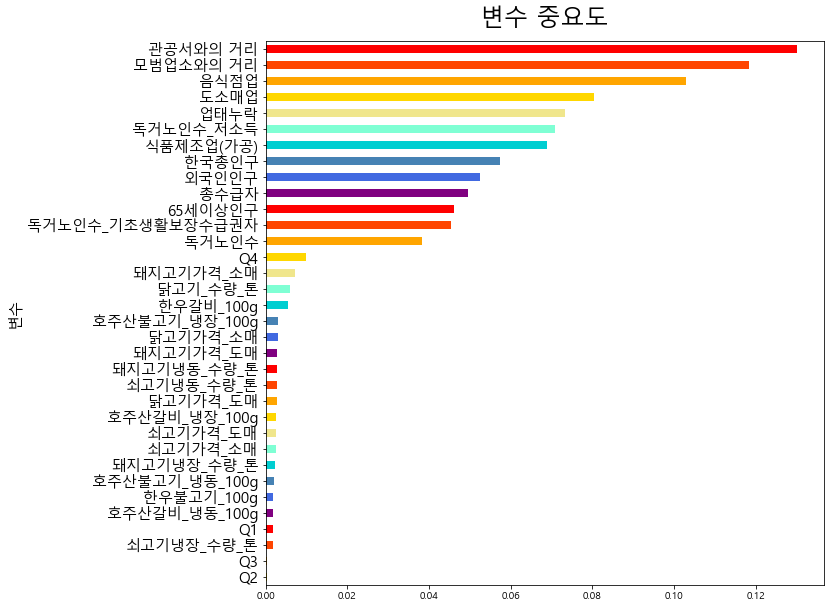

In [48]:
matplotlib.rcParams['font.family'] = 'Malgun Gothic'  # 맑은 고딕으로 폰트 설정 
matplotlib.rcParams['axes.unicode_minus'] = False    # 마이너스(-) 폰트 깨짐 방지

plt.figure(figsize=(10,10))
colors = ['red','orangered', 'orange', 'gold', 'khaki','aquamarine', 'darkturquoise', 'steelblue', 'royalblue', 'purple']

(pd.Series(regr.feature_importances_, index=x_train.columns)
   .nlargest(35)
   .plot(kind='barh', color = colors).invert_yaxis())  

plt.title('변수 중요도', fontsize = 24, pad = 15)
plt.ylabel('변수', fontsize = 15)
plt.yticks(fontsize = 15)
plt.savefig('./머신러닝_시각화/12월_ExtraTreesRegressor_변수중요도.png', dpi=200, facecolor='#eeeeee', bbox_inches='tight')
plt.show()

# 7. 월별 머신러닝 모델들의 성능 비교

In [49]:
%%time
model_list = ['월', 'AdaBoost', 'BaggingRegressor', 'ExtraTreesRegressor', 'GradientBoostingRegressor', 'StackingRegressor', 'VotingRegressor', 'HistGradientBoostingRegressor', 'LightGBM', 'XGBoost']
all_rmse = pd.DataFrame(columns=model_list)
all_rmse['월'] = np.arange(1, 13)
for i in all_rmse['월'].values:
    print("Process : {} | Total : 12".format(i), end='\r')
    # 2010~2018년도를 train data로, 2019년을 test data로 사용하여 월별로 뽑아옴
    # 1~12 월별로 train, test 분리
    dataset_train = dataset[(dataset['조사년도'] <= 2018) & (dataset['조사월'] == i)]  
    dataset_test = dataset[(dataset['조사년도'] == 2019) & (dataset['조사월'] == i)]

    # scaling
    x_train = dataset_train.iloc[:, 3:-1]   # 조사년도, 조사월, id_행정동_match 칼럼은 제외하고 변수만 사용
    y_train = pd.DataFrame(dataset_train.iloc[:, -1], index = dataset_train.index, columns = ['적발건수'])   # index를 보존한 채 data를 split하기 위해 데이터프레임 형태로 만들기

    x_test = dataset_test.iloc[:, 3:-1]     # 조사년도, 조사월, id_행정동_match 칼럼은 제외하고 변수만 사용
    y_test = pd.DataFrame(dataset_test.iloc[:, -1], index = dataset_test.index, columns = ['적발건수'])     # index를 보존한 채 data를 split하기 위해 데이터프레임 형태로 만들기

    x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size = 0.2, random_state=0)    # 2010~2018년 train data를 다시 train, validation data로 나눔

    # x_train, y_train 각각에 MinMaxScaler를 fit하여 transform 진행
    scaler_x = MinMaxScaler(feature_range=(0,1)) # normalize the features
    scaler_x.fit(x_train)
    x_train_scaled = scaler_x.transform(x_train)
    x_test_scaled = scaler_x.transform(x_test)
    x_val_scaled = scaler_x.transform(x_val)

    scaler_y = MinMaxScaler(feature_range=(0,1)) # normalize the features
    scaler_y.fit(y_train)
    y_train_scaled = scaler_y.transform(y_train)
    y_test_scaled = scaler_y.transform(y_test)
    y_val_scaled = scaler_y.transform(y_val)
    
    # AdaBoost
    regr_ada = AdaBoostRegressor(random_state=0, n_estimators=50)
    regr_ada.fit(x_train_scaled, y_train_scaled)

    y_pred_ada = regr_ada.predict(x_val_scaled) 

    rmse_ada = np.sqrt(mean_squared_error(y_val_scaled, y_pred_ada))

    all_rmse.iloc[i-1, 1] = rmse_ada    # 월별 AdaBoost의 RMSE 입력

    # BaggingRegressor
    regr_bag = BaggingRegressor(base_estimator=SVR(), n_estimators=10, random_state=0).fit(x_train_scaled, y_train_scaled)

    y_pred_bag = regr_bag.predict(x_val_scaled) 

    rmse_bag = np.sqrt(mean_squared_error(y_val_scaled, y_pred_bag))

    all_rmse.iloc[i-1, 2] = rmse_bag    # 월별 BaggingRegressor의 RMSE 입력

    # ExtraTreesRegressor
    regr_et = ExtraTreesRegressor(n_estimators=100, random_state=0).fit(x_train_scaled, y_train_scaled)

    y_pred_et = regr_et.predict(x_val_scaled) 

    rmse_et = np.sqrt(mean_squared_error(y_val_scaled, y_pred_et))

    all_rmse.iloc[i-1, 3] = rmse_et    # 월별 ExtraTreesRegressor의 RMSE 입력

    # GradientBoostingRegressor
    regr_gbr = GradientBoostingRegressor(n_estimators=100, random_state=0).fit(x_train_scaled, y_train_scaled)

    y_pred_gbr = regr_gbr.predict(x_val_scaled) 

    rmse_gbr = np.sqrt(mean_squared_error(y_val_scaled, y_pred_gbr))

    all_rmse.iloc[i-1, 4] = rmse_gbr    # 월별 GradientBoostingRegressor의 RMSE 입력

    # StackingRegressor
    estimators = [('lr', RidgeCV()),
                  ('svr', LinearSVR(random_state=0))]
    regr_sr = StackingRegressor(estimators=estimators,
                            final_estimator=RandomForestRegressor(n_estimators=100, random_state=0)).fit(x_train_scaled, y_train_scaled)

    y_pred_sr = regr_sr.predict(x_val_scaled) 

    rmse_sr = np.sqrt(mean_squared_error(y_val_scaled, y_pred_sr))

    all_rmse.iloc[i-1, 5] = rmse_sr    # 월별 StackingRegressor의 RMSE 입력

    # VotingRegressor
    r1 = LinearRegression()
    r2 = RandomForestRegressor(n_estimators=100, random_state=0)
    regr_vr = VotingRegressor([('lr', r1), ('rf', r2)]).fit(x_train_scaled, y_train_scaled)

    y_pred_vr = regr_vr.predict(x_val_scaled) 

    rmse_vr = np.sqrt(mean_squared_error(y_val_scaled, y_pred_vr))

    all_rmse.iloc[i-1, 6] = rmse_vr    # 월별 VotingRegressor의 RMSE 입력

    # HistGradientBoostingRegressor
    regr_hgbr = HistGradientBoostingRegressor(random_state = 0).fit(x_train_scaled, y_train_scaled)

    y_pred_hgbr = regr_hgbr.predict(x_val_scaled) 

    rmse_hgbr = np.sqrt(mean_squared_error(y_val_scaled, y_pred_hgbr))

    all_rmse.iloc[i-1, 7] = rmse_hgbr    # 월별 HistGradientBoostingRegressor의 RMSE 입력

    # LightGBM
    regr_lgbm = lgb.LGBMRegressor(random_state=0, n_jobs = -1)

    regr_lgbm.fit(x_train_scaled, y_train_scaled)

    y_pred_lgbm = regr_lgbm.predict(x_val_scaled) 

    rmse_lgbm = np.sqrt(mean_squared_error(y_val_scaled, y_pred_lgbm))

    all_rmse.iloc[i-1, 8] = rmse_lgbm    # 월별 LightGBM의 RMSE 입력

    # XGBoost
    regr_xgb = XGBRegressor(random_state = 0, n_jobs = -1)

    regr_xgb.fit(x_train_scaled, y_train_scaled)

    y_pred_xgb = regr_xgb.predict(x_val_scaled) 

    rmse_xgb = np.sqrt(mean_squared_error(y_val_scaled, y_pred_xgb))

    all_rmse.iloc[i-1, 9] = rmse_xgb    # 월별 XGBoost의 RMSE 입력
    
all_rmse

Wall time: 5min 47sl : 12


,월,AdaBoost,BaggingRegressor,ExtraTreesRegressor,GradientBoostingRegressor,StackingRegressor,VotingRegressor,HistGradientBoostingRegressor,LightGBM,XGBoost
0,1,0.123537,0.104846,0.0581266,0.0575248,0.0640627,0.0562821,0.0567845,0.057455,0.0620003
1,2,0.182309,0.109781,0.0822982,0.0760123,0.0808482,0.0755702,0.0796439,0.078531,0.0871244
2,3,0.201955,0.192349,0.185996,0.185063,0.189999,0.181045,0.183556,0.184143,0.188602
3,4,0.128126,0.128528,0.0972496,0.0915351,0.105449,0.0962862,0.0982115,0.0981845,0.0973981
4,5,0.0281544,0.0756824,0.0242979,0.0227712,0.0260337,0.0200397,0.0209164,0.0212303,0.0255155
5,6,0.16015,0.106324,0.060282,0.054378,0.0661946,0.0546286,0.0572263,0.0570453,0.0563195
6,7,0.110077,0.10622,0.0628621,0.059347,0.0669118,0.0586131,0.0592557,0.0591003,0.0635497
7,8,0.0613531,0.0963022,0.0270733,0.0242145,0.0278098,0.0242375,0.0248014,0.024772,0.0271903
8,9,0.208092,0.105154,0.0650857,0.0607714,0.0686333,0.0607742,0.0611185,0.0612412,0.065183
9,10,0.0914601,0.11775,0.0697987,0.0628682,0.0780049,0.0703437,0.0714238,0.0717962,0.0710955


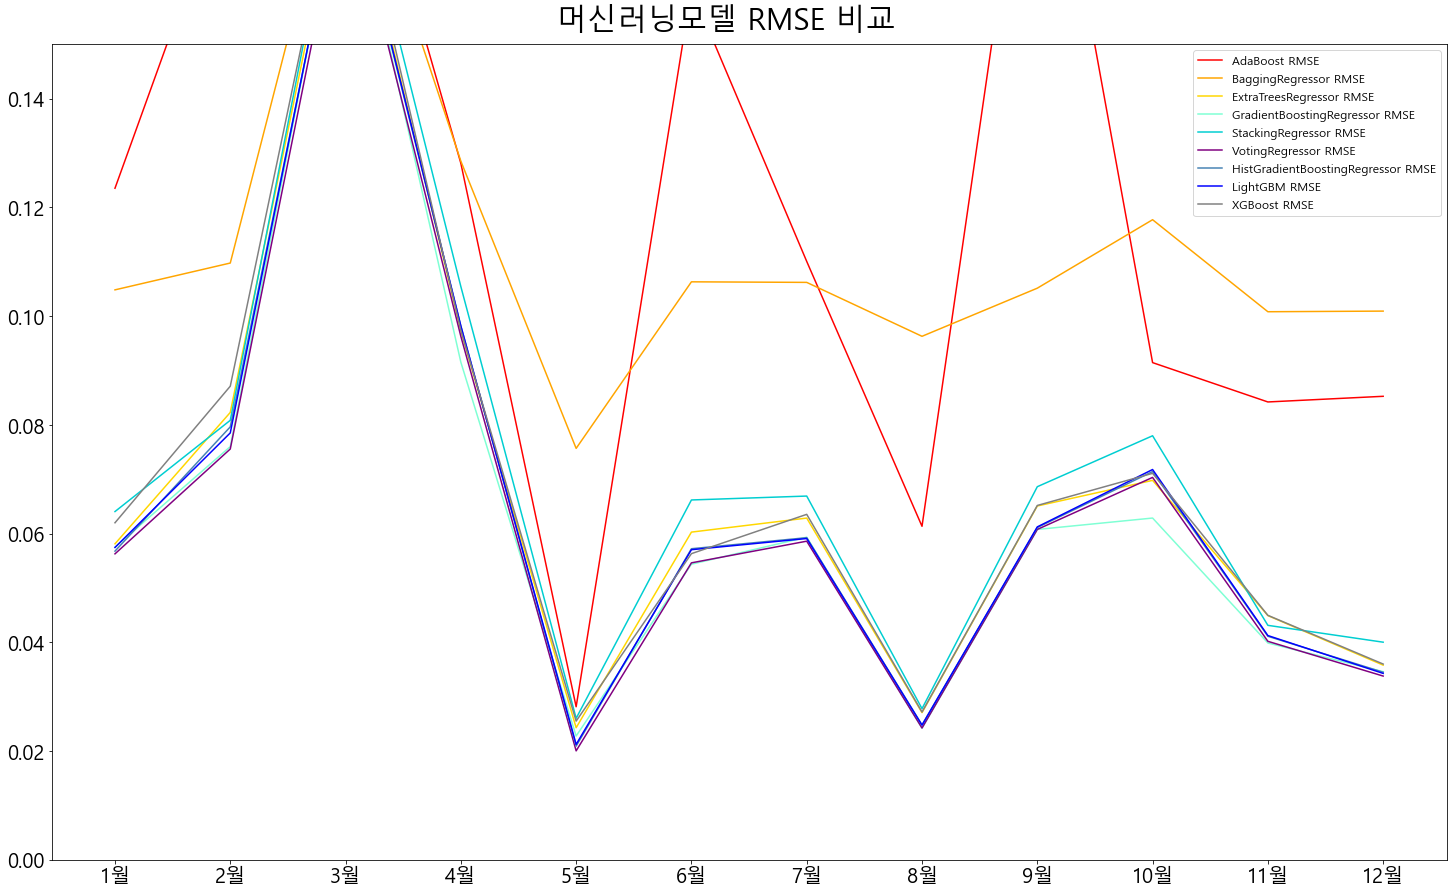

In [50]:
fig, ax = plt.subplots(figsize = (25, 15))

x = list(map(lambda x: str(x) + '월', all_rmse['월']))

line1 = ax.plot(x, all_rmse['AdaBoost'], color = 'red')
line2 = ax.plot(x, all_rmse['BaggingRegressor'], color = 'orange')
line3 = ax.plot(x, all_rmse['ExtraTreesRegressor'],color = 'gold')
line4 = ax.plot(x, all_rmse['GradientBoostingRegressor'],color = 'aquamarine')
line5 = ax.plot(x, all_rmse['StackingRegressor'], color = 'darkturquoise')
line6 = ax.plot(x, all_rmse['VotingRegressor'], color = 'purple')
line7 = ax.plot(x, all_rmse['HistGradientBoostingRegressor'], color = 'steelblue')
line8 = ax.plot(x, all_rmse['LightGBM'], color = 'blue')
line9 = ax.plot(x, all_rmse['XGBoost'], color = 'gray')

# x, y축 글꼴 크게
ax.tick_params(axis='both', which='major', labelsize=20)

# y축 범위 설정
ax.set_ylim(0, 0.15)

# 범례 설정
ax.legend(['AdaBoost RMSE',
            'BaggingRegressor RMSE',
            'ExtraTreesRegressor RMSE',
            'GradientBoostingRegressor RMSE',
            'StackingRegressor RMSE',
            'VotingRegressor RMSE',
            'HistGradientBoostingRegressor RMSE',
            'LightGBM RMSE',
            'XGBoost RMSE'], loc = 0, fontsize = 'large')

# 제목
fig.suptitle('머신러닝모델 RMSE 비교', fontsize = 30, y=0.915)
plt.savefig('./머신러닝_시각화/머신러닝모델_성능비교.png', dpi=200, facecolor='#eeeeee', bbox_inches='tight')
plt.show()